### Import Libraries

In [21]:
%matplotlib inline
import torch
import os
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [22]:
DATA_DIR = '../input/dogs-cats-images/dataset'
TRAIN_DIR = DATA_DIR + "/training_set"
TEST_DIR = DATA_DIR + "/test_set"


In [23]:
classes = os.listdir(TRAIN_DIR)
print(classes)

['dogs', 'cats']


Let's look inside folders, training set and from the test set. 

In [24]:
cats = os.listdir(TRAIN_DIR + "/cats")
print('No. of training examples for cats:', len(cats))
print(cats[:5])

No. of training examples for cats: 4000
['cat.3498.jpg', 'cat.891.jpg', 'cat.2842.jpg', 'cat.1.jpg', 'cat.115.jpg']


In [25]:
dogs = os.listdir(TRAIN_DIR + "/dogs")
print('No. of training examples for dogs:', len(dogs))
print(dogs[:5])

No. of training examples for dogs: 4000
['dog.3443.jpg', 'dog.1942.jpg', 'dog.375.jpg', 'dog.3259.jpg', 'dog.790.jpg']


In [26]:
cats = os.listdir(TEST_DIR + "/cats")
print('No. of testing examples for cats:', len(cats))
print(cats[:5])

No. of testing examples for cats: 1000
['cat.4414.jpg', 'cat.4420.jpg', 'cat.4880.jpg', 'cat.4326.jpg', 'cat.4620.jpg']


In [28]:
dogs = os.listdir(TEST_DIR + "/dogs")
print('No. of testing examples for dogs:', len(dogs))
print(dogs[:5])

No. of testing examples for dogs: 1000
['dog.4329.jpg', 'dog.4223.jpg', 'dog.4253.jpg', 'dog.4190.jpg', 'dog.4354.jpg']


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [29]:
from torchvision.datasets import ImageFolder

Since the data consists of color images with 3 channels (RGB), each image tensor has the shape of varying size.So we are resizing the image to have same shape (200,200)

In [30]:
transform = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
dataset = ImageFolder(DATA_DIR+'/training_set', transform=transform)
test_dataset = ImageFolder(DATA_DIR+'/test_set', transform=transform)


Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of color images with 3 channels (RGB)

In [31]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 100, 100]) 0


tensor([[[0.1569, 0.1569, 0.1804,  ..., 0.4471, 0.7255, 0.7882],
         [0.1451, 0.1412, 0.1608,  ..., 0.4431, 0.7020, 0.7843],
         [0.1529, 0.1373, 0.1451,  ..., 0.4275, 0.7176, 0.8000],
         ...,
         [0.0824, 0.0784, 0.0863,  ..., 0.2902, 0.3098, 0.2549],
         [0.0941, 0.0824, 0.0863,  ..., 0.2510, 0.2118, 0.1804],
         [0.1098, 0.0863, 0.0941,  ..., 0.3098, 0.1843, 0.1804]],

        [[0.1765, 0.1725, 0.1922,  ..., 0.4588, 0.7176, 0.7765],
         [0.1647, 0.1529, 0.1725,  ..., 0.4549, 0.6902, 0.7608],
         [0.1725, 0.1490, 0.1569,  ..., 0.4392, 0.6980, 0.7647],
         ...,
         [0.0784, 0.0745, 0.0784,  ..., 0.2235, 0.2510, 0.2039],
         [0.0863, 0.0745, 0.0784,  ..., 0.1843, 0.1569, 0.1333],
         [0.1020, 0.0784, 0.0863,  ..., 0.2431, 0.1294, 0.1333]],

        [[0.1647, 0.1804, 0.2157,  ..., 0.4667, 0.6392, 0.6471],
         [0.1529, 0.1647, 0.1961,  ..., 0.4745, 0.6235, 0.6471],
         [0.1608, 0.1608, 0.1804,  ..., 0.4627, 0.6431, 0.

As a internal functionality, the list of classes is stored in the .classes property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [32]:
print(dataset.classes)

['cats', 'dogs']


We can view the image using matplotlib, but we need to change the tensor dimensions to (100,100,3). Notice, for matplotlib the channel should be specified in the third position. Let's create a helper function to display an image and its label.

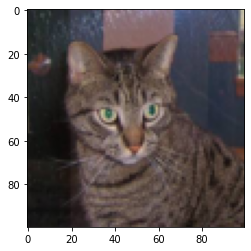

In [35]:
array = img.numpy()

# display the image using Matplotlib
plt.imshow(array.transpose(1, 2, 0))
plt.show()


In [33]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  cats (0)


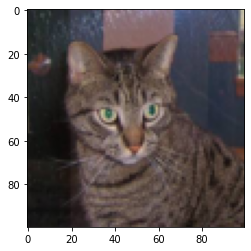

In [34]:
show_example(*dataset[0])

Label:  dogs (1)


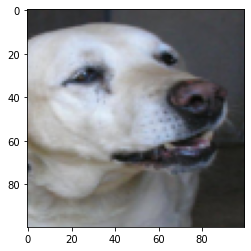

In [36]:
show_example(*dataset[4800])

### Training and Validation Datasets
While building real world machine learning models, it is quite common to split the dataset into 3 parts:

- Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
- Validation set - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
- Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model. 
Since there's no predefined validation set, we can set aside a small portion of the training set to be used as the validation set. We'll use the random_split helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator

In [37]:
random_seed = 42
torch.manual_seed(random_seed);

In [38]:
len(dataset)

8000

In [39]:
val_size = 2000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(6000, 2000)

### DataLoader
We can now created data loaders to help us load the data in batches. Large datasets requires loading them into memory all at once. This leads to memory outage and slowing down of programs. PyTorch offers a solution for parallelizing the data loading process with the support of automatic batching as well. This is the DataLoader class present within the torch.utils.data package.

We'll use a batch size of 64, we will load 64 samples at a time until all the 6000 images in the training set are loaded and trained to complete 1 epoch.

### What is batch size?
The number of samples (data points) that would be passed through the network at a time.

### What is epoch?
An epoch is one single pass of all the input data through the network.

### Relation between batch_size and epoch?
batch_size is not equal to epoch, consider you have 1000 images. Processing all the 1000 images through the network once is considered as 1 epoch. If we set the batch size as 10, during training we will be passing 100 data points (=1000/10) at a time until we eventually pass in all the training data to complete 1 single epoch.

Generally, larger the batch size faster the training. However, you need to have enough hardware to handle. Sometimes, even if our machine can handle heavy computation,by setting larger batch size quality of the model could degrade and could create difficulty in generalizing.

In [40]:
batch_size=64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)

We can look at batches of images from the dataset using the make_grid method from torchvision. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [41]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

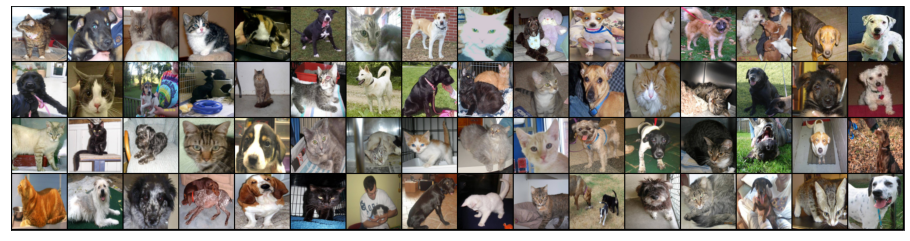

In [42]:
show_batch(train_loader)

In [48]:
def image_convert(img):
    img = img.clone().cpu().numpy()
    img = img.transpose(1,2,0)
#     std = [0.5,0.5,0.5]
#     mean = [0.5,0.5,0.5]
#     img = img*std + mean
    return img


def plot_10():
    iter_ = iter(train_loader)
    images,labels = next(iter_)
    an_ = {'0':'cat','1':'dog'}

    plt.figure(figsize=(20,10))
    for idx in range(10):
        plt.subplot(2,5,idx+1)
        img = image_convert(images[idx])
        label = labels[idx]
        plt.imshow(img)
        plt.title(an_[str(label.numpy())])
    plt.show()

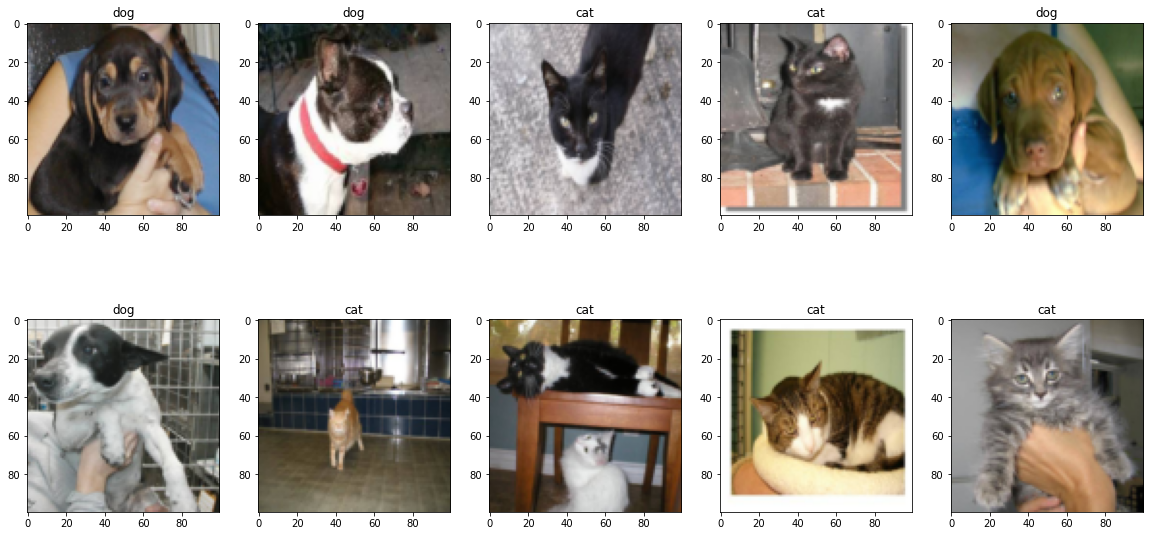

In [49]:
plot_10()

### Evaluation Metric and Loss Function
Let's first define out evaluation metric, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the accuracy of the prediction

In [50]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Here we are using torch.max() function, this function's default behaviour as you can guess by the name is to return maximum among the elements in the Tensor. However, this function also helps get the maximum along a particular dimension, as a Tensor, instead of a single element. To specify the dimension (axis – in numpy), there is another optional keyword argument, called dim. This represents the direction that we take for the maximum.

max_elements, max_indices = torch.max(input_tensor, dim)

- dim=0, (maximum along columns).
- dim=1 (maximum along rows).

This returns a tuple, max_elements and max_indices.

- max_elements -> All the maximum elements of the Tensor.
- max_indices -> Indices corresponding to the maximum elements.

In the above accuracy function, the == performs an element-wise comparison of two tensors with the same shape, and returns a tensor of the same shape, containing 0s for unequal elements, and 1s for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

### Loss Function
While the accuracy is a great way for us (humans) to evaluate the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:

It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

Due to these reasons, accuracy is a great evaluation metric for classification, but not a good loss function. A commonly used loss function for classification problems is the cross entropy,

### How Cross Entropy works
For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are [0.1, 0.3, 0.2, ...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.

Then, take the logarithm of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function.

PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the outputs of the model without converting them into probabilities.

In [51]:
class ImageClassificationModelBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_loss'], result['val_loss'], result['val_acc']))

### Model

In [69]:
# class ImageClassificationModel(ImageClassificationModelBase):
#     def __init__(self):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1), #output 32 X 100 X 100 | (Receptive Field (RF) -  3 X 3
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),   #output 64 X 100 X 100 | RF 5 X 5
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 64 x 50 x 50 | RF 10 X 10

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # output: 128 x 50 x 50 | RF 12 X 12
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 128 x 25 x 25  | RF 24 X 24
            
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # output: 256 x 25 x 25  | RF 26 X 26
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 256 x 12 x 12 | RF 52 X 52
            
#             nn.Conv2d(256, 512, kernel_size=3, stride=1), #output 512* 10* 10 | RF 54 X 54
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 512 x 5 x 5 | RF - 108X 108
            
#             nn.Conv2d(512, 1024, kernel_size=3, stride=1),#1024 X 3 X 3 | Rf - 110 X 110
#             nn.ReLU(),
# #             nn.MaxPool2d(2, 2), # output: 1024 x 4 x 4
            
#             nn.Conv2d(1024, 2048, kernel_size=3, stride=1), # output: 1024x2048 , 1x 1


#             nn.Flatten(),
#             #nn.Linear(512 * 5 * 5,10))
#             nn.Linear(1024 * 2 * 2, 2))
         
#     def forward(self, xb):
#         return self.network(xb)


class ImageClassificationModel(ImageClassificationModelBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), #output 32 X 100 X 100 | (Receptive Field (RF) -  3 X 3
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),   #output 64 X 100 X 100 | RF 5 X 5
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 50 x 50 | RF 10 X 10

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # output: 128 x 50 x 50 | RF 12 X 12
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 25 x 25  | RF 24 X 24
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # output: 256 x 25 x 25  | RF 26 X 26
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 12 x 12 | RF 52 X 52
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1), #output 512* 10* 10 | RF 54 X 54
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 5 x 5 | RF - 108X 108
            
            nn.Conv2d(512, 1024, kernel_size=3, stride=1),#1024 X 3 X 3 | Rf - 110 X 110
            nn.ReLU(),
            #nn.MaxPool2d(2, 2), # output: 1024 x 4 x 4
            
            nn.Conv2d(1024, 2048, kernel_size=3, stride=1), # output: 2048 x 1 x 1


            nn.AdaptiveAvgPool2d((1,1)), # Global Average Pooling
            nn.Flatten(),
            nn.Linear(2048, 2),
            nn.LogSoftmax(dim=1) # or nn.Softmax(dim=1) if not using nn.NLLLoss()
        )
         
    def forward(self, xb):
        return self.network(xb)


### Using a GPU
As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers.


In [70]:
#function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# a function that can move data and model to a chosen device.    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


#Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move data to the selected device, 
#as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. 
#All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [71]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our data loaders using DeviceDataLoader.

In [72]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

### Training the Model

In [73]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the to_device function to move the model's parameters to the right device.

In [74]:
model = to_device(ImageClassificationModel(), device)


In [75]:

!pip install torchsummary

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [76]:
from torchsummary import summary
# print the summary of the model
summary(model, input_size=(3, 100, 100), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             896
              ReLU-2         [-1, 32, 100, 100]               0
            Conv2d-3         [-1, 64, 100, 100]          18,496
              ReLU-4         [-1, 64, 100, 100]               0
         MaxPool2d-5           [-1, 64, 50, 50]               0
            Conv2d-6          [-1, 128, 50, 50]          73,856
              ReLU-7          [-1, 128, 50, 50]               0
         MaxPool2d-8          [-1, 128, 25, 25]               0
            Conv2d-9          [-1, 256, 25, 25]         295,168
             ReLU-10          [-1, 256, 25, 25]               0
        MaxPool2d-11          [-1, 256, 12, 12]               0
           Conv2d-12          [-1, 512, 10, 10]       1,180,160
             ReLU-13          [-1, 512, 10, 10]               0
        MaxPool2d-14            [-1, 51

In [77]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.6931619644165039, 'val_acc': 0.50634765625}]

In [78]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 0.7553, val_loss: 0.6930, val_acc: 0.5093
Epoch [1], train_loss: 0.6938, val_loss: 0.6931, val_acc: 0.5093
Epoch [2], train_loss: 0.6934, val_loss: 0.6933, val_acc: 0.4907
Epoch [3], train_loss: 0.6934, val_loss: 0.6932, val_acc: 0.4907
Epoch [4], train_loss: 0.6933, val_loss: 0.6932, val_acc: 0.4907
Epoch [5], train_loss: 0.6934, val_loss: 0.6940, val_acc: 0.4907
Epoch [6], train_loss: 0.6934, val_loss: 0.6931, val_acc: 0.5093
Epoch [7], train_loss: 0.6933, val_loss: 0.6930, val_acc: 0.5093
Epoch [8], train_loss: 0.6941, val_loss: 0.6931, val_acc: 0.5093
Epoch [9], train_loss: 0.6935, val_loss: 0.6932, val_acc: 0.4907
Epoch [10], train_loss: 0.6937, val_loss: 0.6932, val_acc: 0.5093
Epoch [11], train_loss: 0.6936, val_loss: 0.6934, val_acc: 0.4907
Epoch [12], train_loss: 0.6932, val_loss: 0.6931, val_acc: 0.4907
Epoch [13], train_loss: 0.6933, val_loss: 0.6932, val_acc: 0.4907
Epoch [14], train_loss: 0.6932, val_loss: 0.6931, val_acc: 0.5093
Epoch [15], train_lo

In [79]:
def plot_scores(history):
#     scores = [x['val_score'] for x in history]
    acc = [x['val_acc'] for x in history]
    plt.plot(acc, '-x')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('acc vs. No. of epochs');

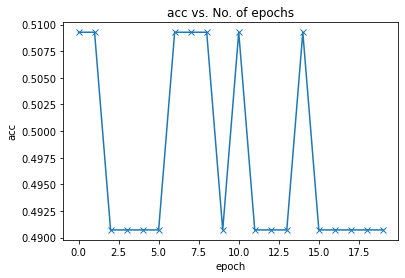

In [80]:
plot_scores(history)


In [81]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

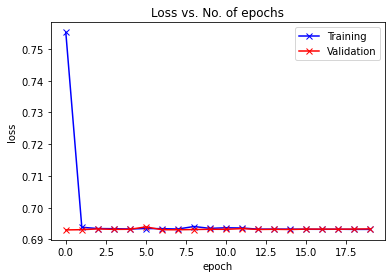

In [82]:
plot_losses(history)
